# Convolutional Autoeconder with dropout
This code trains a simple autoencoder neural network using convolutional
 layers.The contraction and expansion of the implemented neural network used
only convolutional layers. Therefore, it does not rely on maxpooling or
upsampling layers. Instead, it was used strides to control the contraction
and expansion of the neural network. Also, in the decoder part it was used a
decovolutional process.

For the latent space it was used a fully connected layer with an additional
fully connected layer in sequence, to connect the latent space with the
decoder convolutional layer.

The dropout layer is used as mean to prevent the neural network to overfit. 
It works by randomly removing a neuron or a filter of a layer during the 
training stage. It forces the neural network to find a path to the output
without relying only in a small set of neurons.

The neural network architecture with the activation function is stated below.

## Prelimiary steps

In [ ]:
# Optional cell if the current path already has the data and the file utils.py
%cd .. 
%cd .. 

In [14]:
import h5py
import keras.layers as layers
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Model

from utils import plot_red_comp, slicer, split

# Path to store training data
save_path = "./tests/jupyter-notebooks/models/train_ae_conv_drop_{}"

###  Data manipulation

In [15]:
# Selecting data
dt_fl = "nn_data.h5"
dt_dst = "scaled_data"

# The percentage for the test is implicit
n_train = 0.8
n_valid = 0.1

# Select the variable to train
# 0: Temperature - 1: Pressure - 2: Velocity - None: all
var = 2

Load the selected data and then split it.

In [16]:
# Open data file
f = h5py.File(dt_fl, "r")
dt = f[dt_dst]

# Split data file
idxs = split(dt.shape[0], n_train, n_valid)
slc_trn, slc_vld, slc_tst = slicer(dt.shape, idxs, var=var)
# Slice data
x_train = dt[slc_trn][:, :, :, np.newaxis]
x_val = dt[slc_vld][:, :, :, np.newaxis]

# Convert the var into a slice
if var:
    slc = slice(var, var + 1)
else:
    slc = slice(var)

### Autoencoder settings

In [17]:
# Autoencoder settings

# Activation function
act = "tanh"  # Convolutional layers activation function
act_lt = "tanh"  # Latent space layers activation function
# Number of filters of each layer
flt = [3, 9, 27]
# Filter size
flt_size = 5
# Strides of each layer
strd = [2, 2, 5]
# Dropout value
e_dp = [0.2, 0.2, 0.2]  # Encoder dropout
d_dp = [0.2, 0.2, 0.2]  # Decoder dropout
# Latent space size
lt_sz = 50
lt_dp = 0.8 # Dropout at the latent space

# Training settings
opt = "adam"  # Optimizer
loss = "mse"
epochs = 60
batch_size = 64

### Build autoencoder

In [18]:
# Build the autoencoder neural network
tf.keras.backend.clear_session()
flt_tp = (flt_size, flt_size)
conv_kwargs = dict(activation=act, padding="same")
# Encoder
inputs = layers.Input(shape=x_train.shape[1:])
e = layers.Conv2D(flt[0], flt_tp, strides=strd[0], **conv_kwargs)(inputs)
e = layers.Dropout(e_dp[0])(e)
e = layers.Conv2D(flt[1], flt_tp, strides=strd[1], **conv_kwargs)(e)
e = layers.Dropout(e_dp[1])(e)
e = layers.Conv2D(flt[2], flt_tp, strides=strd[2], **conv_kwargs)(e)
e = layers.Dropout(e_dp[1])(e)

# Latent space
l = layers.Flatten()(e)
l = layers.Dense(lt_sz, activation=act_lt)(l)

# Latent to decoder
dn_flt = flt[-1]
d_shp = (x_train.shape[1:-1] / np.prod(strd)).astype(int)
d_sz = np.prod(d_shp) * dn_flt
d = layers.Dense(d_sz, activation=act_lt)(l)
d = layers.Reshape(np.hstack((d_shp, dn_flt)))(d)
# Decoder
d = layers.Conv2DTranspose(flt[-1], flt_tp, strides=strd[-1], **conv_kwargs)(d)
d = layers.Dropout(d_dp[0])(d)
d = layers.Conv2DTranspose(flt[-2], flt_tp, strides=strd[-2], **conv_kwargs)(d)
d = layers.Dropout(d_dp[0])(d)
d = layers.Conv2DTranspose(flt[-3], flt_tp, strides=strd[-3], **conv_kwargs)(d)
d = layers.Dropout(d_dp[0])(d)
decoded = layers.Conv2DTranspose(
    x_train.shape[-1], flt_tp, activation="linear", padding="same"
)(d)

# Mount the autoencoder
ae = Model(inputs, decoded, name="Convolutional Autoencoder with dropout")

In [19]:
# Show the architecture
ae.summary()

Model: "Convolutional Autoencoder with dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 50, 3)        78        
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50, 3)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 25, 9)         684       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 25, 9)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 5, 27)         6102      
_________________________________________________________________
dropout_3 (Dropout)         

## Callbacks
Early stopping to stop training when the validation loss start to increase
The patience term is a number of epochs to wait before stop. Also, the
'restore_best_weights' is used to restore the best model against the
validation dataset. It is necessary as not always the best model against
the validation dataset is the last neural network weights.

In [20]:
# Callbacks
monitor = "val_loss"
patience = int(epochs * 0.3)
es = EarlyStopping(
    monitor=monitor, mode="min", patience=patience, restore_best_weights=True
)

### Training

In [21]:
# Compile and train
ae.compile(optimizer=opt, loss=loss)
hist = ae.fit(
    x_train,
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_val, x_val),
    callbacks=[es],
)

Train on 1133 samples, validate on 141 samples
Epoch 1/60
1133/1133 [==============================] - 2s 2ms/step - loss: 0.9132 - val_loss: 0.6713
Epoch 2/60
1133/1133 [==============================] - 1s 1ms/step - loss: 0.6430 - val_loss: 0.4869
Epoch 3/60
1133/1133 [==============================] - 1s 1ms/step - loss: 0.4534 - val_loss: 0.3376
Epoch 4/60
1133/1133 [==============================] - 1s 1ms/step - loss: 0.3654 - val_loss: 0.2824
Epoch 5/60
1133/1133 [==============================] - 1s 1ms/step - loss: 0.3104 - val_loss: 0.2425
Epoch 6/60
1133/1133 [==============================] - 1s 1ms/step - loss: 0.2752 - val_loss: 0.2213
Epoch 7/60
1133/1133 [==============================] - 1s 1ms/step - loss: 0.2488 - val_loss: 0.1990
Epoch 8/60
1133/1133 [==============================] - 1s 1ms/step - loss: 0.2298 - val_loss: 0.1887
Epoch 9/60
1133/1133 [==============================] - 1s 1ms/step - loss: 0.2160 - val_loss: 0.1781
Epoch 10/60
1133/1133 [============

### Save trained model

In [22]:
# Save the model
ae.save(save_path.format("model.h5"))

# Store the test dataset
x_tst = dt[slc_tst][:, :, :, np.newaxis]
np.save(save_path.format("test.npy"), x_tst)

### Training process

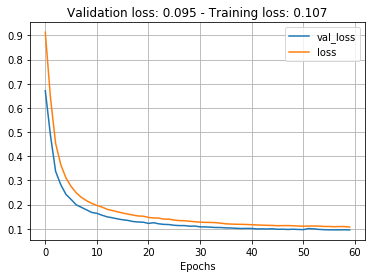

In [23]:
# Convert the history to a Pandas dataframe
hist_df = pd.DataFrame(hist.history)
hist_df.index.name = "Epochs"
# Save the training history
hist_df.to_hdf(save_path.format("hist.h5"), 'his')

# Plot training evolution
tit = "Validation loss: {:.3f} - Training loss: {:.3f}".format(*hist_df.min())
hist_df.plot(grid=True, title=tit)

### Evaluate the trained model

In [24]:
# Test the trained neural network against the test dataset
x_test = dt[slc_tst][:, :, :, np.newaxis]
loss = ae.evaluate(x_test, x_test)
print("Test dataset loss: {:.3f}".format(loss))

global_loss = ae.evaluate(dt[:, :, :, slc], dt[:, :, :, slc])
print("Entire dataset loss: {:.3f}".format(global_loss))

141/141 [==============================] - 0s 443us/step
Test dataset loss: 0.109
1415/1415 [==============================] - 1s 422us/step
Entire dataset loss: 0.090


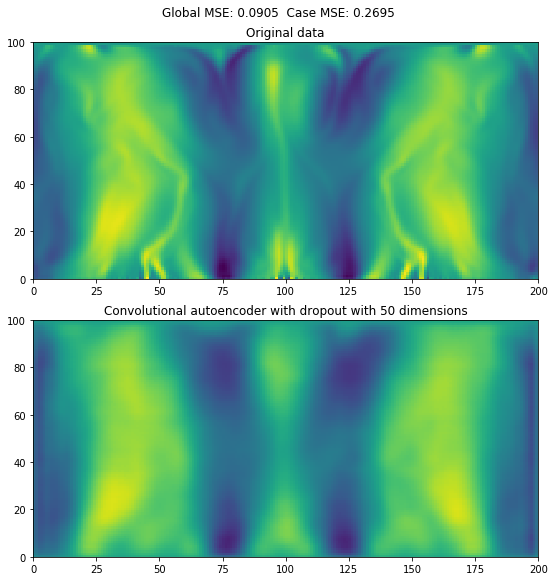

In [25]:
# Comparing the input and output of the autoencoder neural network
data_index = 634

# Slice the data
dt_in = dt[data_index, :, :, slc]
# Get the neural network output
dt_out = ae.predict(dt_in[np.newaxis])
# Plot
alg = "Convolutional autoencoder with dropout"
plot_red_comp(dt_in, dt_out[0], 0, lt_sz, global_loss, alg)